In [46]:
import pandas as pd
import os
import sys
from sklearn import datasets
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [47]:
#Importing Configs
# Define the path where config.py is located
os.chdir('/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling')
config_file_path = os.getcwd()
print(config_file_path)

# Add this path to the sys.path
sys.path.append(config_file_path)

import config
finbert_models = config.finbert_models

/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling


In [48]:
us_speech = pd.read_csv(f"{finbert_models}/Fed/Speeches/Fed_Speeches_finbert_model_short.csv")
us_speech['date'] = pd.to_datetime(us_speech['date'])
us_speech = us_speech[['date', 'sentiment', 'positive', 'negative', 'neutral']]
us_speech = us_speech.rename(columns={'sentiment': 'speech_sentiment', 'positive': 'speech_positive', 'negative': 'speech_negative', 'neutral': 'speech_neutral'})
us_speech = us_speech.groupby('date').mean().reset_index()
us_minutes = pd.read_csv(f"{finbert_models}/Fed/Minutes/Fed_Minutes_finbert_model_short.csv")
us_minutes['date'] = pd.to_datetime(us_minutes['date'])
us_minutes = us_minutes[['date', 'sentiment', 'positive', 'negative', 'neutral']]
us_minutes = us_minutes.rename(columns={'sentiment': 'minutes_sentiment', 'positive': 'minutes_positive', 'negative': 'minutes_negative', 'neutral': 'minutes_neutral'})
us_minutes = us_minutes.groupby('date').mean().reset_index()
us_statements = pd.read_csv(f"{finbert_models}/Fed/Statements/Fed_Statements_finbert_model_short.csv")
us_statements['date'] = pd.to_datetime(us_statements['date'])
us_statements = us_statements[['date', 'sentiment', 'positive', 'negative', 'neutral']]
us_statements = us_statements.rename(columns={'sentiment': 'statements_sentiment', 'positive': 'statements_positive', 'negative': 'statements_negative', 'neutral': 'statements_neutral'})
us_statements = us_statements.groupby('date').mean().reset_index()
us_beigebooks = pd.read_csv(f"{finbert_models}/Fed/Beige Book/Fed_Beige Book_finbert_model_short.csv")
us_beigebooks['date'] = pd.to_datetime(us_beigebooks['date'])
us_beigebooks = us_beigebooks[['date', 'sentiment', 'positive', 'negative', 'neutral']]
us_beigebooks = us_beigebooks.rename(columns={'sentiment': 'beigebooks_sentiment', 'positive': 'beigebooks_positive', 'negative': 'beigebooks_negative', 'neutral': 'beigebooks_neutral'})
us_beigebooks = us_beigebooks.groupby('date').mean().reset_index()

sentiment_us = us_speech.copy(deep=True)
sentiment_us = pd.merge(sentiment_us, us_minutes, how='outer', on='date')
sentiment_us = pd.merge(sentiment_us, us_statements, how='outer', on='date')
sentiment_us = pd.merge(sentiment_us, us_beigebooks, how='outer', on='date')


In [49]:
eu_speech = pd.read_csv(f"{finbert_models}/ECB/Speeches/ECB_Speeches_finbert_model_short.csv")
eu_speech['date'] = pd.to_datetime(eu_speech['date'])
eu_speech = eu_speech[['date', 'sentiment', 'positive', 'negative', 'neutral']]
eu_speech = eu_speech.rename(columns={'sentiment': 'speech_sentiment', 'positive': 'speech_positive', 'negative': 'speech_negative', 'neutral': 'speech_neutral'})
eu_speech = eu_speech.groupby('date').mean().reset_index()

eu_mpd = pd.read_csv(f"{finbert_models}/ECB/Monetary Policy Decisions/ECB_Monetary Policy Decisions_finbert_model_short.csv")
eu_mpd['date'] = pd.to_datetime(eu_mpd['date'])
eu_mpd = eu_mpd[['date', 'sentiment', 'positive', 'negative', 'neutral']]
eu_mpd = eu_mpd.rename(columns={'sentiment': 'mpd_sentiment', 'positive': 'mpd_positive', 'negative': 'mpd_negative', 'neutral': 'mpd_neutral'})
eu_mpd = eu_mpd.groupby('date').mean().reset_index()

eu_pressconf = pd.read_csv(f"{finbert_models}/ECB/Press Conferences/ECB_Press Conferences_finbert_model_short.csv")
eu_pressconf['date'] = pd.to_datetime(eu_pressconf['date'])
eu_pressconf = eu_pressconf[['date', 'sentiment', 'positive', 'negative', 'neutral']]
eu_pressconf = eu_pressconf.rename(columns={'sentiment': 'pressconf_sentiment', 'positive': 'pressconf_positive', 'negative': 'pressconf_negative', 'neutral': 'pressconf_neutral'})
eu_pressconf = eu_pressconf.groupby('date').mean().reset_index()

eu_eb = pd.read_csv(f"{finbert_models}/ECB/Economic Bulletin/ECB_Economic Bulletin_finbert_model_short.csv")
eu_eb['date'] = pd.to_datetime(eu_eb['date'], format='%Y-%m-%d')
eu_eb = eu_eb[['date', 'sentiment', 'positive', 'negative', 'neutral']]
eu_eb = eu_eb.rename(columns={'sentiment': 'eb_sentiment', 'positive': 'eb_positive', 'negative': 'eb_negative', 'neutral': 'eb_neutral'})
eu_eb = eu_eb.groupby('date').mean().reset_index()

sentiment_eu = eu_speech.copy(deep=True)
sentiment_eu = pd.merge(sentiment_eu, eu_mpd, how='outer', on='date')
sentiment_eu = pd.merge(sentiment_eu, eu_pressconf, how='outer', on='date')
sentiment_eu = pd.merge(sentiment_eu, eu_eb, how='outer', on='date')

In [50]:
sentiment_eu['date'] = pd.to_datetime(sentiment_eu['date'], format='%Y-%m-%d')

In [51]:
sentiment_us = sentiment_us[(sentiment_us['date'] >= '2000-01-01') & (sentiment_us['date'] <= '2023-06-30')]
sentiment_eu = sentiment_eu[(sentiment_eu['date'] >= '2000-01-01') & (sentiment_eu['date'] <= '2023-06-30')]



In [52]:
sentiment_us = sentiment_us.resample('Q', on='date').mean().reset_index()
sentiment_eu = sentiment_eu.resample('Q', on='date').mean().reset_index()

In [53]:
filter_items = ['speech_sentiment', 'minutes_sentiment', 'statements_sentiment', 'beigebooks_sentiment']

for item in filter_items:
    filter_df = sentiment_us.copy(deep=True)
    filter_df = filter_df[['date', f'{item}']]

    cycle, trend = sm.tsa.filters.hpfilter(filter_df[f'{item}'], 1600)
    #cycle, trend = sm.tsa.filters.hpfilter(filter_df[f'{item}'], (100*(12**2)))

    item_decomp = filter_df[[f'{item}']]
    item_decomp[f"{item}_cycle"] = cycle
    item_decomp[f"{item}_trend"] = trend

    filter_df = pd.merge(filter_df, item_decomp, on=f'{item}', how='left')  
    filter_df = filter_df[['date', f'{item}_cycle']]
    sentiment_us = sentiment_us.drop(columns=[f'{item}'])
    filter_df = filter_df.rename(columns={f'{item}_cycle': f'{item}'})
    sentiment_us = pd.merge(sentiment_us, filter_df, on='date', how='left')

In [54]:
filter_items = ['speech_sentiment', 'mpd_sentiment', 'pressconf_sentiment', 'eb_sentiment']

for item in filter_items:
    filter_df = sentiment_eu.copy(deep=True)
    filter_df = filter_df[['date', f'{item}']]

    cycle, trend = sm.tsa.filters.hpfilter(filter_df[f'{item}'], 1600)
    #cycle, trend = sm.tsa.filters.hpfilter(filter_df[f'{item}'], (100*(12**2)))

    item_decomp = filter_df[[f'{item}']]
    item_decomp[f"{item}_cycle"] = cycle
    item_decomp[f"{item}_trend"] = trend

    filter_df = pd.merge(filter_df, item_decomp, on=f'{item}', how='left')  
    filter_df = filter_df[['date', f'{item}_cycle']]
    sentiment_eu = sentiment_eu.drop(columns=[f'{item}'])
    filter_df = filter_df.rename(columns={f'{item}_cycle': f'{item}'})
    sentiment_eu = pd.merge(sentiment_eu, filter_df, on='date', how='left')

In [55]:
sent_us = pd.read_csv(f"{finbert_models}/Fed/Minutes/Fed_Minutes_finbert_model_short.csv")
sent_us['date'] = pd.to_datetime(sent_us['date'])
sent_eu = pd.read_csv(f"{finbert_models}/ECB/Monetary policy decisions/ECB_Monetary policy decisions_finbert_model_short.csv")
sent_eu['date'] = pd.to_datetime(sent_eu['date'])

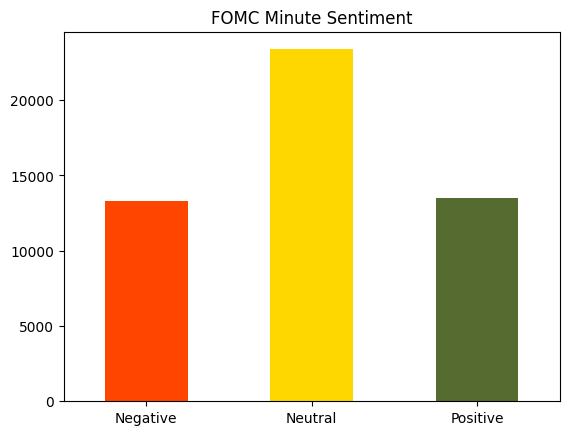

In [56]:
fig, ax = plt.subplots()
sent_us['sentiment'].value_counts().sort_index().plot(ax=ax, kind='bar', color=['orangered', 'Gold', 'darkolivegreen'])
ax.set_title('FOMC Minute Sentiment')
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=0)
ax.set_xlabel('')  # Remove the x label
plt.show()

In [57]:
sent_us2 = sent_us.copy(deep=True)
sent_eu2 = sent_eu.copy(deep=True)

sent_us2 = sent_us2[['date', 'positive', 'negative', 'neutral']]
sent_eu2 = sent_eu2[['date', 'positive', 'negative', 'neutral']]

sent_us2 = sent_us2.groupby('date').sum().reset_index()
sent_eu2 = sent_eu2.groupby('date').sum().reset_index()

sent_us2 = sent_us2.resample('Q', on='date').sum().reset_index()
sent_eu2 = sent_eu2.resample('Q', on='date').sum().reset_index()

sent_us2['total'] = sent_us2['positive'] + sent_us2['negative'] + sent_us2['neutral']
sent_eu2['total'] = sent_eu2['positive'] + sent_eu2['negative'] + sent_eu2['neutral']

sent_us2['positive'] = sent_us2['positive'] / sent_us2['total']
sent_us2['negative'] = sent_us2['negative'] / sent_us2['total']
sent_us2['neutral'] = sent_us2['neutral'] / sent_us2['total']

sent_eu2['positive'] = sent_eu2['positive'] / sent_eu2['total']
sent_eu2['negative'] = sent_eu2['negative'] / sent_eu2['total']
sent_eu2['neutral'] = sent_eu2['neutral'] / sent_eu2['total']

In [58]:
sent_us = sent_us[['date', 'sentiment']]
sent_eu = sent_eu[['date', 'sentiment']]

sent_us = sent_us.groupby('date').mean().reset_index()
sent_eu = sent_eu.groupby('date').mean().reset_index()

sent_us = sent_us[sent_us['date'] > '2000-01-01']
sent_eu = sent_eu[sent_eu['date'] > '2000-01-01']

sent_us = sent_us.resample('Q', on='date').mean().reset_index()
sent_eu = sent_eu.resample('Q', on='date').mean().reset_index()

In [59]:
filter_items = ['sentiment']

for item in filter_items:
    filter_df = sent_us.copy(deep=True)
    filter_df = filter_df[['date', f'{item}']]

    cycle, trend = sm.tsa.filters.hpfilter(filter_df[f'{item}'], 1600)
    #cycle, trend = sm.tsa.filters.hpfilter(filter_df[f'{item}'], (100*(12**2)))

    item_decomp = filter_df[[f'{item}']]
    item_decomp[f"{item}_cycle"] = cycle
    item_decomp[f"{item}_trend"] = trend

    filter_df = pd.merge(filter_df, item_decomp, on=f'{item}', how='left')  
    filter_df = filter_df[['date', f'{item}_cycle', f'{item}_trend']]
    sent_us = pd.merge(sent_us, filter_df, on='date', how='left')
    
sent_us = sent_us.drop(columns=['sentiment', 'sentiment_trend'])
sent_us = sent_us.rename(columns={'sentiment_cycle': 'sentiment'})

In [60]:
filter_items = ['sentiment']

for item in filter_items:
    filter_df = sent_eu.copy(deep=True)
    filter_df = filter_df[['date', f'{item}']]

    cycle, trend = sm.tsa.filters.hpfilter(filter_df[f'{item}'], 1600)
    #cycle, trend = sm.tsa.filters.hpfilter(filter_df[f'{item}'], (100*(8**2)))

    item_decomp = filter_df[[f'{item}']]
    item_decomp[f"{item}_cycle"] = cycle
    item_decomp[f"{item}_trend"] = trend

    filter_df = pd.merge(filter_df, item_decomp, on=f'{item}', how='left')  
    filter_df = filter_df[['date', f'{item}_cycle', f'{item}_trend']]
    sent_eu = pd.merge(sent_eu, filter_df, on='date', how='left')
    
sent_eu = sent_eu.drop(columns=['sentiment', 'sentiment_trend'])
sent_eu = sent_eu.rename(columns={'sentiment_cycle': 'sentiment'})

Text(0.5, 1.0, 'US Federal Reserve FOMC Minutes Sentiment Quarterly with HP Filter')

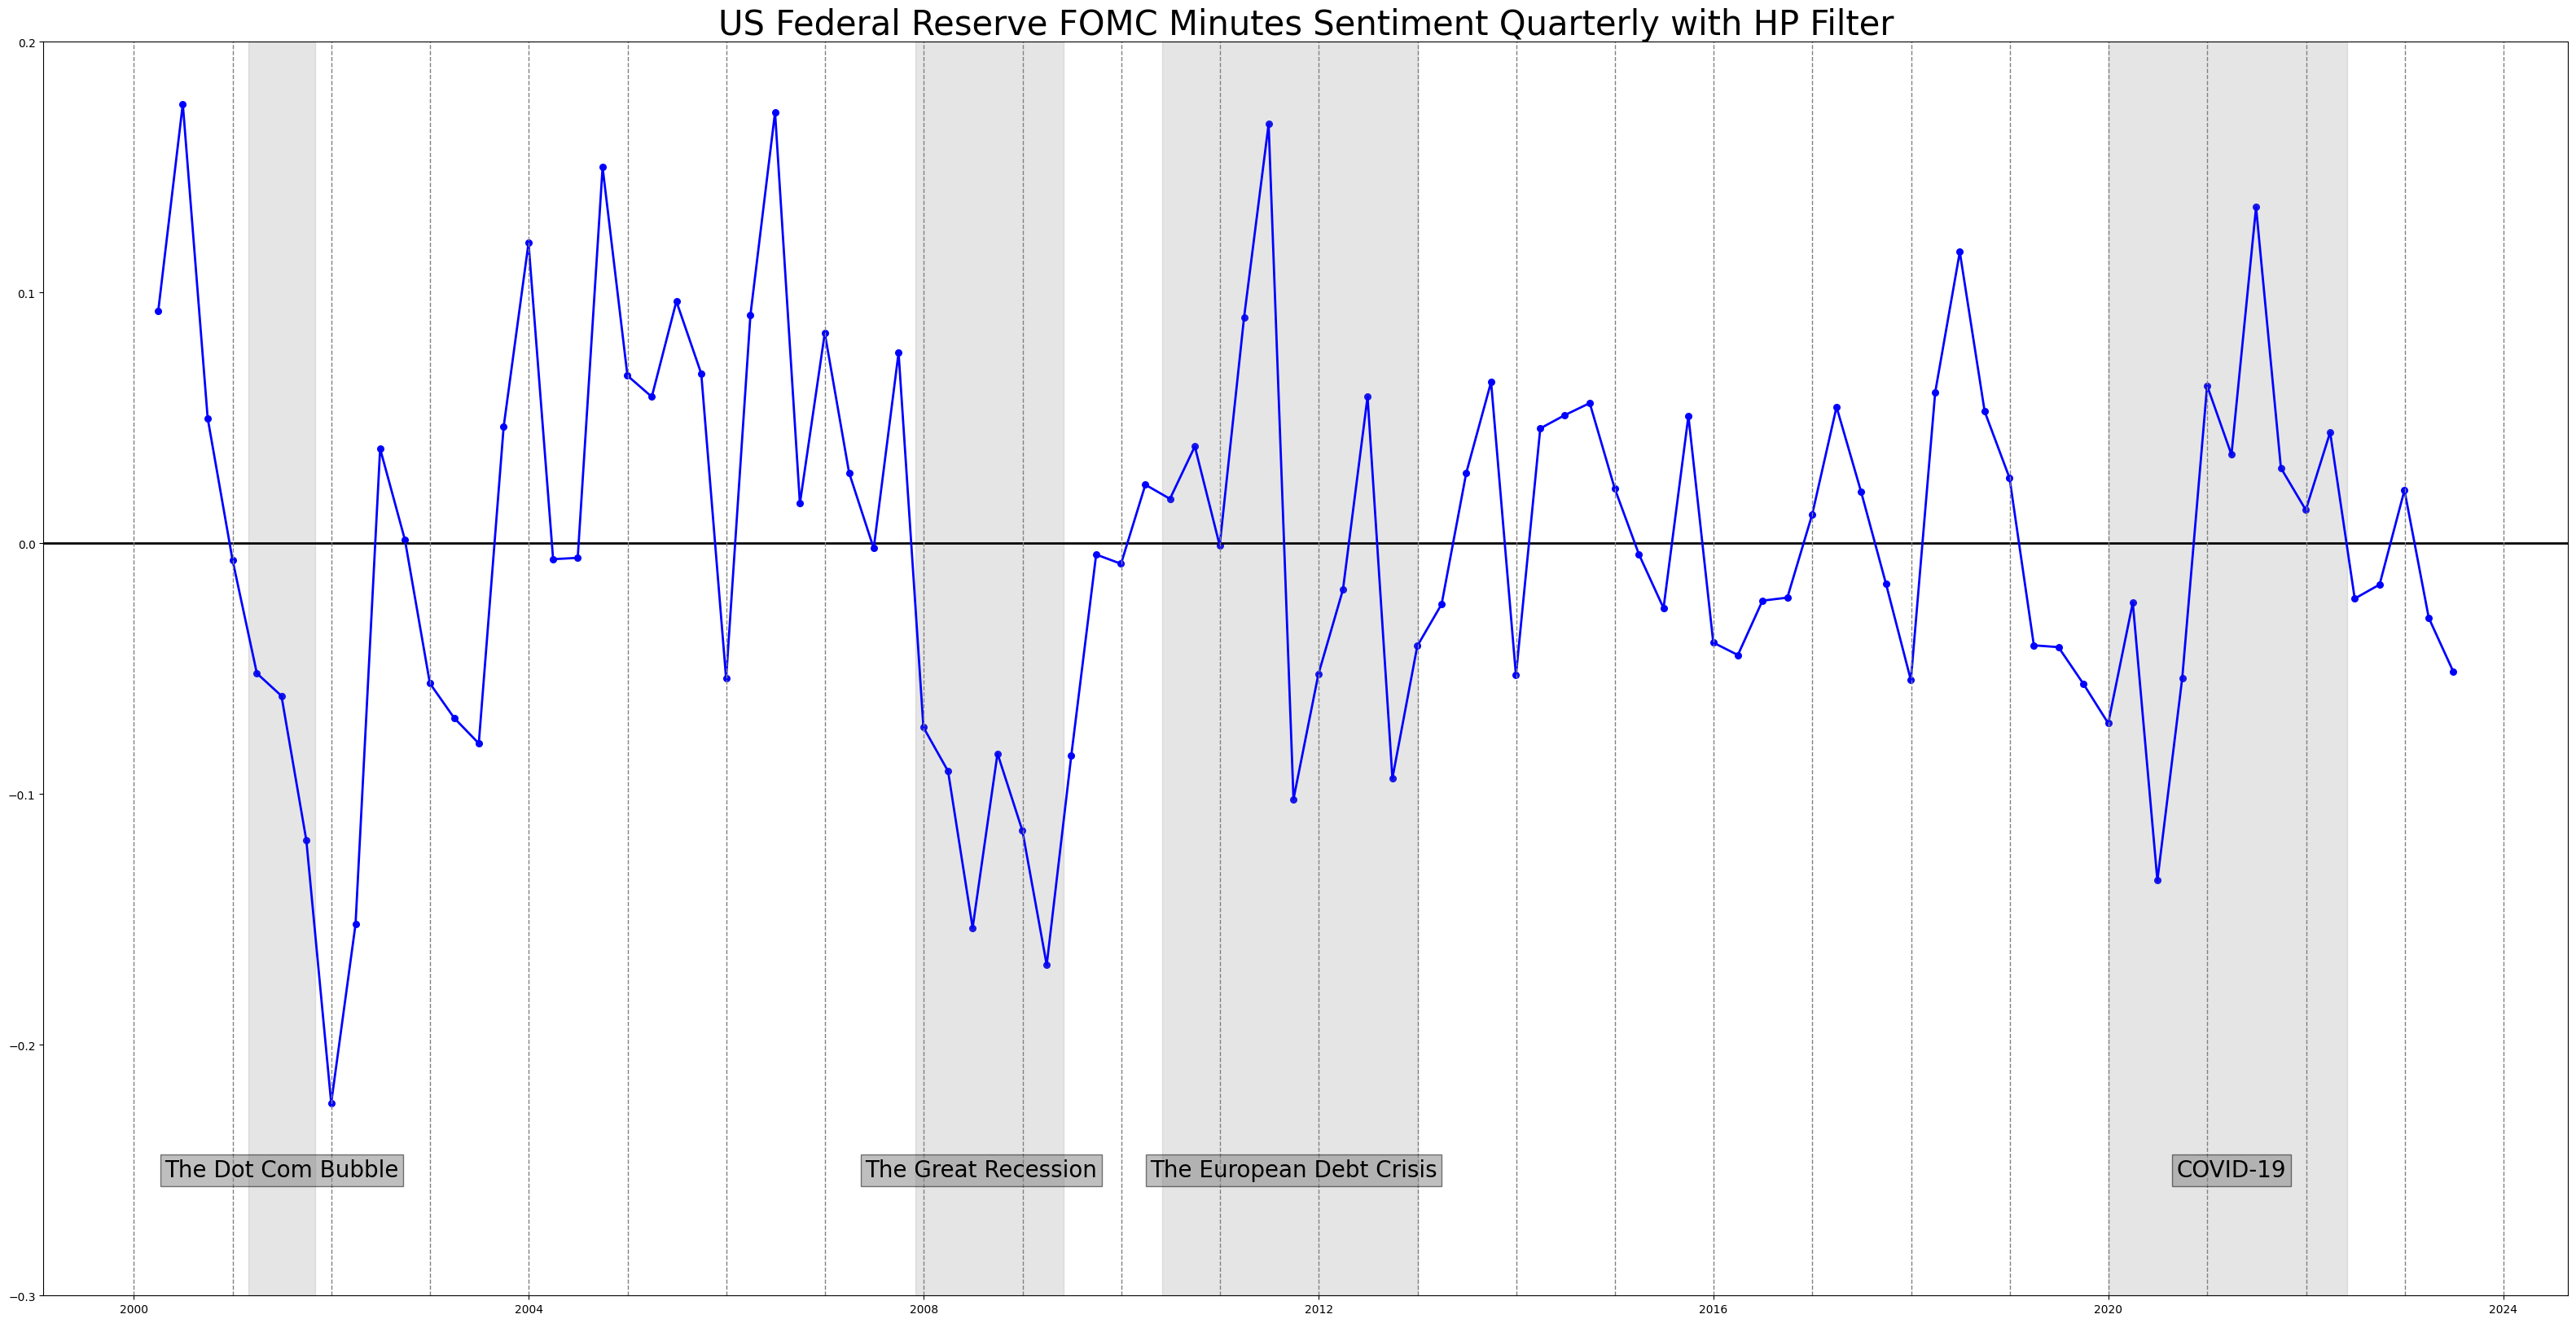

In [61]:
x1 = 'sentiment'

fig, ax = plt.subplots(figsize = (40, 20))

#Create a black line at 0
ax.axhline(0, color='black', lw=2)

ax.scatter(sent_us['date'], sent_us[f'{x1}'], label=f'{x1}', color='blue', s=30)
ax.plot(sent_us['date'], sent_us[f'{x1}'], label=f'{x1}', color='blue', lw=2)

lh = -0.25

#Great Recession
ax.axvspan(pd.to_datetime('2007-12-01'), pd.to_datetime('2009-06-01'), color='gray', alpha=0.2)
ax.text(pd.to_datetime('2008-08-01'), lh, 'The Great Recession',horizontalalignment='center', verticalalignment='center', fontsize=20,  bbox = dict(facecolor = 'gray', alpha = 0.5))

#COVID
ax.axvspan(pd.to_datetime('2020-01-01'), pd.to_datetime('2022-06-01'), color='gray', alpha=0.2)
ax.text(pd.to_datetime('2021-04-01'), lh, 'COVID-19',horizontalalignment='center', verticalalignment='center', fontsize=20,  bbox = dict(facecolor = 'gray', alpha = 0.5))

#European Debt Crisis
ax.axvspan(pd.to_datetime('2010-06-01'), pd.to_datetime('2013-01-01'), color='gray', alpha=0.2)
ax.text(pd.to_datetime('2011-10-01'), lh, 'The European Debt Crisis',horizontalalignment='center', verticalalignment='center', fontsize=20,  bbox = dict(facecolor = 'gray', alpha = 0.5))

#Dot Com Bubble
ax.axvspan(pd.to_datetime('2001-03-01'), pd.to_datetime('2001-11-01'), color='gray', alpha=0.2)
ax.text(pd.to_datetime('2001-07-01'), lh, 'The Dot Com Bubble',horizontalalignment='center', verticalalignment='center', fontsize=20,  bbox = dict(facecolor = 'gray', alpha = 0.5))

for year in range(2000, 2025):
    ax.axvline(pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', lw=1)
    
ax.set_ylim(-0.3, 0.2)
ax.set_title('US Federal Reserve FOMC Minutes Sentiment Quarterly with HP Filter', fontsize=30)

Text(0.5, 1.0, 'ECB Monetary Policy Account Sentiment')

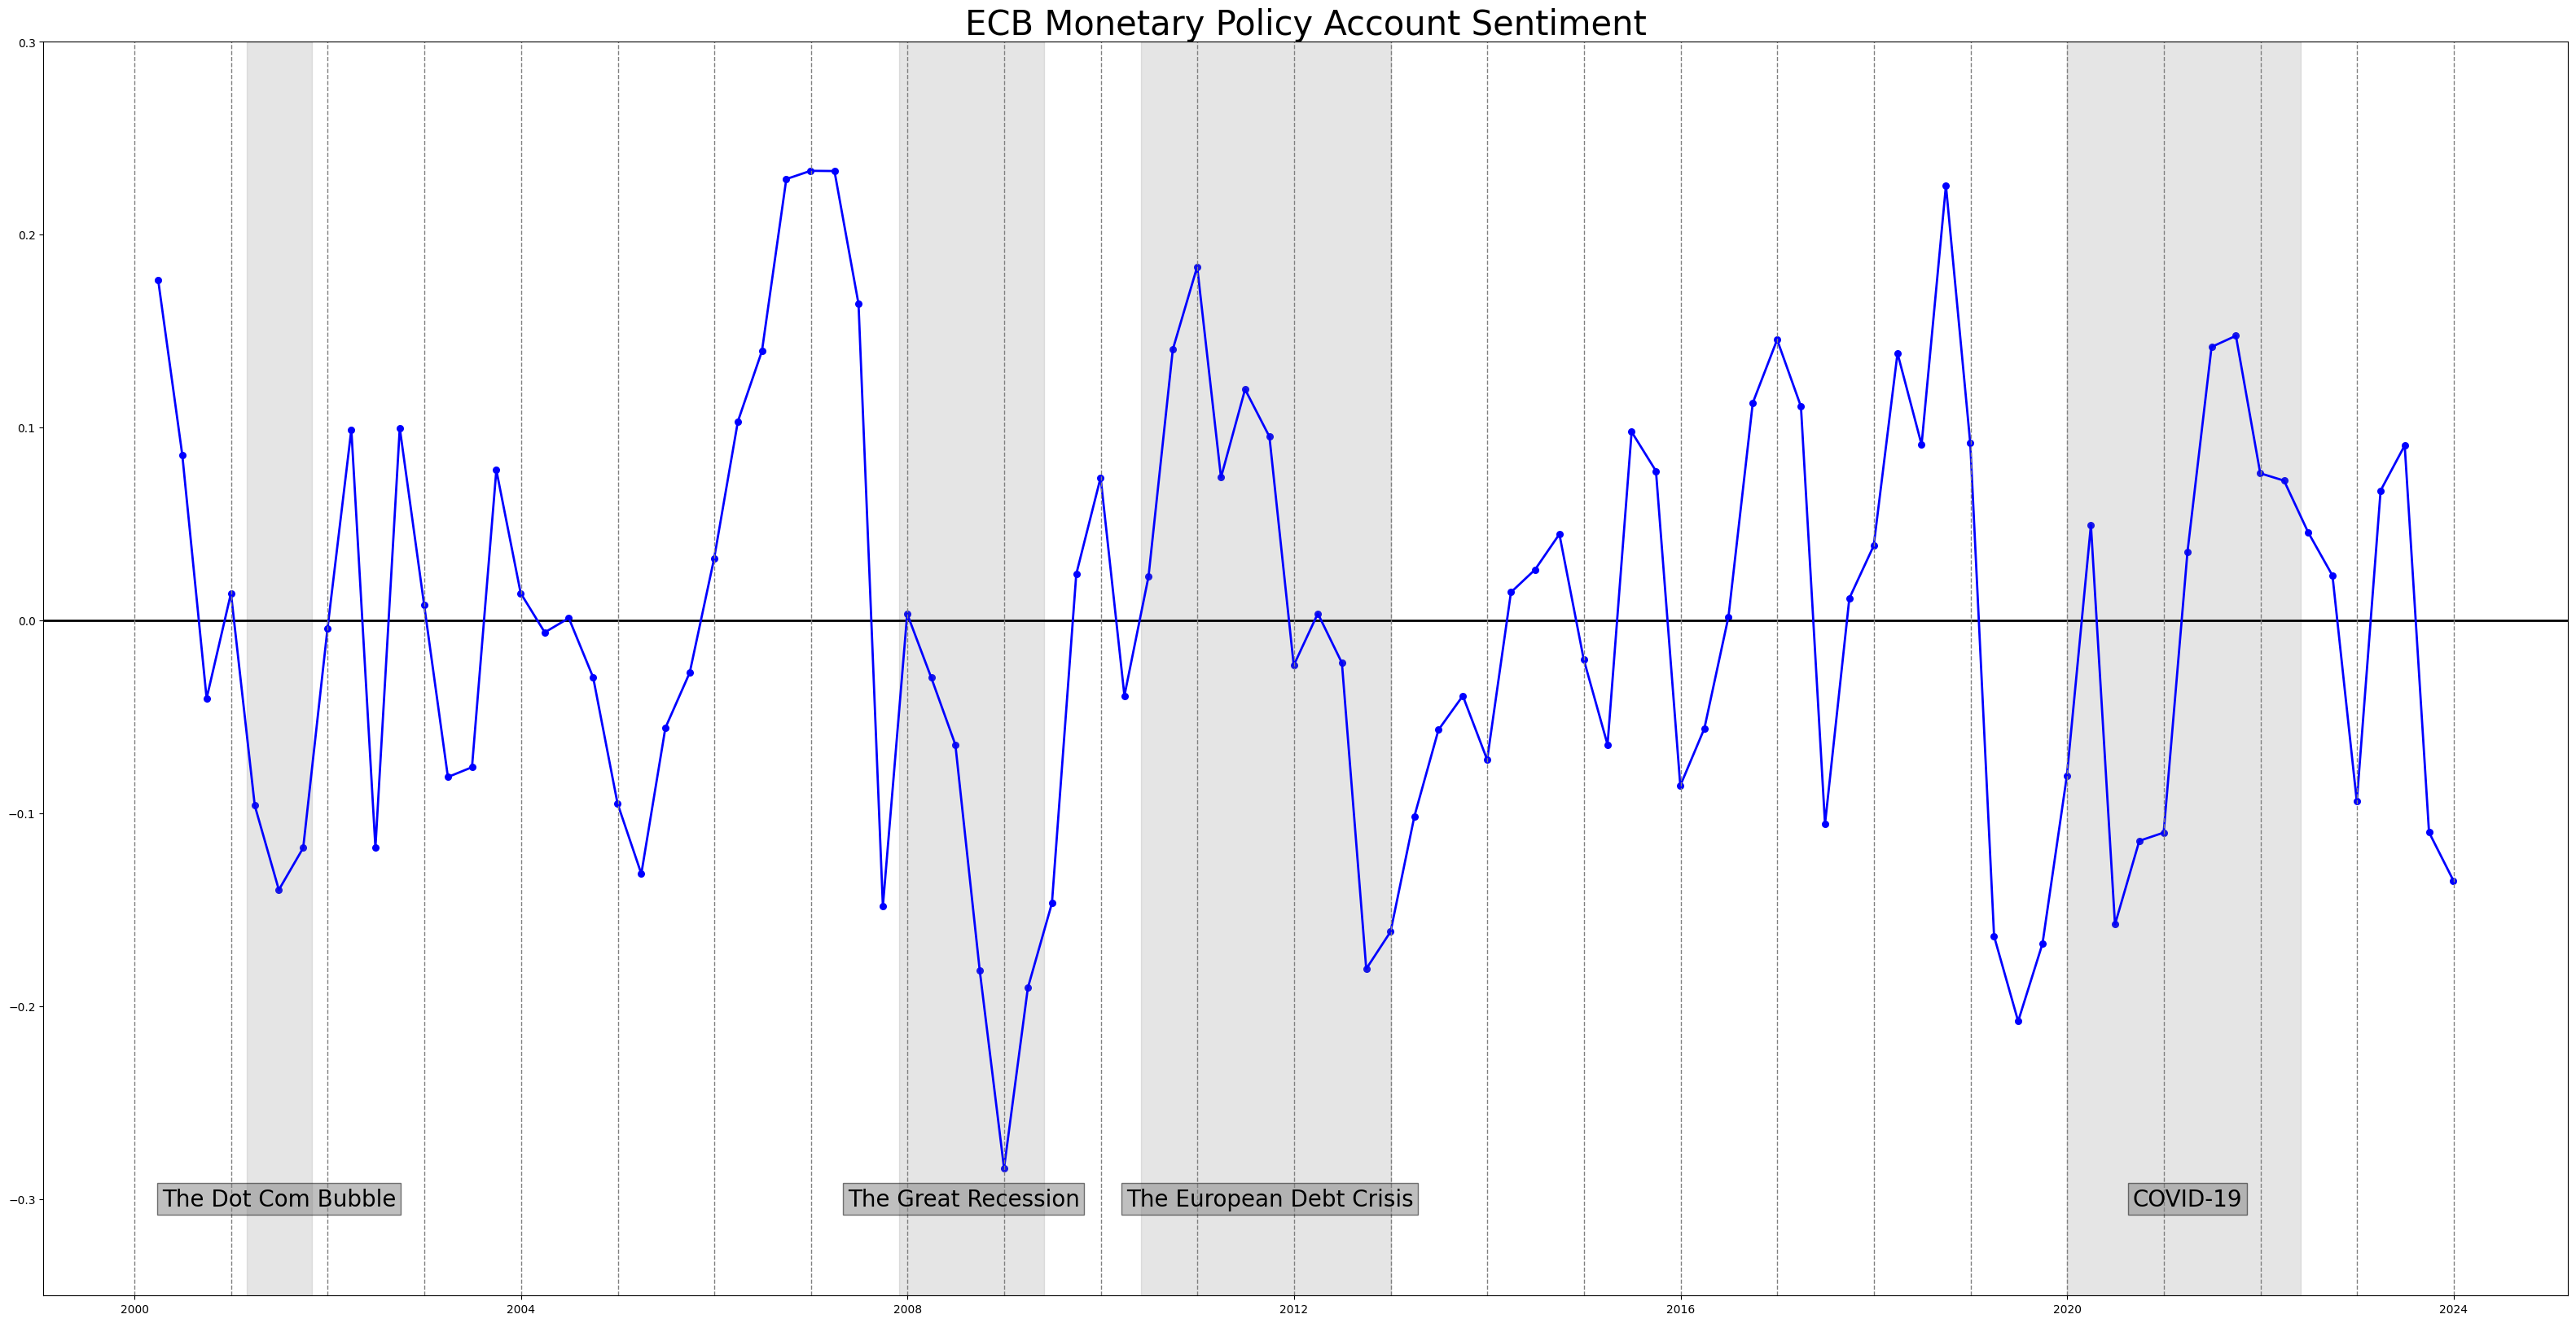

In [62]:
x1 = 'sentiment'

fig, ax = plt.subplots(figsize = (40, 20))

#Create a black line at 0
ax.axhline(0, color='black', lw=2)

ax.scatter(sent_eu['date'], sent_eu[f'{x1}'], label=f'{x1}', color='blue', s=30)
ax.plot(sent_eu['date'], sent_eu[f'{x1}'], label=f'{x1}', color='blue', lw=2)

lh2 = -0.3
#Great Recession
ax.axvspan(pd.to_datetime('2007-12-01'), pd.to_datetime('2009-06-01'), color='gray', alpha=0.2)
ax.text(pd.to_datetime('2008-08-01'), lh2, 'The Great Recession',horizontalalignment='center', verticalalignment='center', fontsize=20,  bbox = dict(facecolor = 'gray', alpha = 0.5))

#COVID
ax.axvspan(pd.to_datetime('2020-01-01'), pd.to_datetime('2022-06-01'), color='gray', alpha=0.2)
ax.text(pd.to_datetime('2021-04-01'), lh2, 'COVID-19',horizontalalignment='center', verticalalignment='center', fontsize=20,  bbox = dict(facecolor = 'gray', alpha = 0.5))

#European Debt Crisis
ax.axvspan(pd.to_datetime('2010-06-01'), pd.to_datetime('2013-01-01'), color='gray', alpha=0.2)
ax.text(pd.to_datetime('2011-10-01'), lh2, 'The European Debt Crisis',horizontalalignment='center', verticalalignment='center', fontsize=20,  bbox = dict(facecolor = 'gray', alpha = 0.5))

#Dot Com Bubble
ax.axvspan(pd.to_datetime('2001-03-01'), pd.to_datetime('2001-11-01'), color='gray', alpha=0.2)
ax.text(pd.to_datetime('2001-07-01'), lh2, 'The Dot Com Bubble',horizontalalignment='center', verticalalignment='center', fontsize=20,  bbox = dict(facecolor = 'gray', alpha = 0.5))

for year in range(2000, 2025):
    ax.axvline(pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', lw=1)
    
ax.set_ylim(-0.35, 0.3)
ax.set_title('ECB Monetary Policy Account Sentiment', fontsize=30)

In [63]:


# fig, ax = plt.subplots(figsize = (40, 20))

# #Create a black line at 0
# ax.axhline(0, color='black', lw=2)

# #create a mixed column graph of positive negative and neutral sentiment overtime
# # ax.bar(sent_us2['date'], sent_us2['positive'], label='positive', color='green', width=5)
# # ax.bar(sent_us2['date'], sent_us2['negative'], label='negative', color='red', width=5)
# # ax.bar(sent_us2['date'], sent_us2['neutral'], label='neutral', color='blue', width=5)

# ax.bar(sent_us2['date'], sent_us2['negative'], label='positive', color='red', width=30)
# ax.bar(sent_us2['date'], sent_us2['neutral'], label='negative', color='yellow', width=30, bottom=sent_us2['negative'])
# ax.bar(sent_us2['date'], sent_us2['positive'], label='neutral', color='green', width=30, bottom=sent_us2['negative'] + sent_us2['neutral'])

# #Great Recession
# ax.axvspan(pd.to_datetime('2007-12-01'), pd.to_datetime('2009-06-01'), color='gray', alpha=0.2)
# ax.text(pd.to_datetime('2008-08-01'), 0.2, 'The Great Recession',horizontalalignment='center', verticalalignment='center', fontsize=20,  bbox = dict(facecolor = 'gray', alpha = 0.5))

# #COVID
# ax.axvspan(pd.to_datetime('2020-01-01'), pd.to_datetime('2022-06-01'), color='gray', alpha=0.2)
# ax.text(pd.to_datetime('2021-04-01'), 0.2, 'COVID-19',horizontalalignment='center', verticalalignment='center', fontsize=20,  bbox = dict(facecolor = 'gray', alpha = 0.5))

# #European Debt Crisis
# ax.axvspan(pd.to_datetime('2010-06-01'), pd.to_datetime('2013-01-01'), color='gray', alpha=0.2)
# ax.text(pd.to_datetime('2011-10-01'), 0.2, 'The European Debt Crisis',horizontalalignment='center', verticalalignment='center', fontsize=20,  bbox = dict(facecolor = 'gray', alpha = 0.5))

# #Dot Com Bubble
# ax.axvspan(pd.to_datetime('2001-03-01'), pd.to_datetime('2001-11-01'), color='gray', alpha=0.2)
# ax.text(pd.to_datetime('2001-07-01'), 0.2, 'The Dot Com Bubble',horizontalalignment='center', verticalalignment='center', fontsize=20,  bbox = dict(facecolor = 'gray', alpha = 0.5))

# for year in range(2000, 2025):
#     ax.axvline(pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', lw=1)
    
# ax.set_title('US Federal Reserve FOMC Minutes Sentiment', fontsize=30)

<BarContainer object of 94 artists>

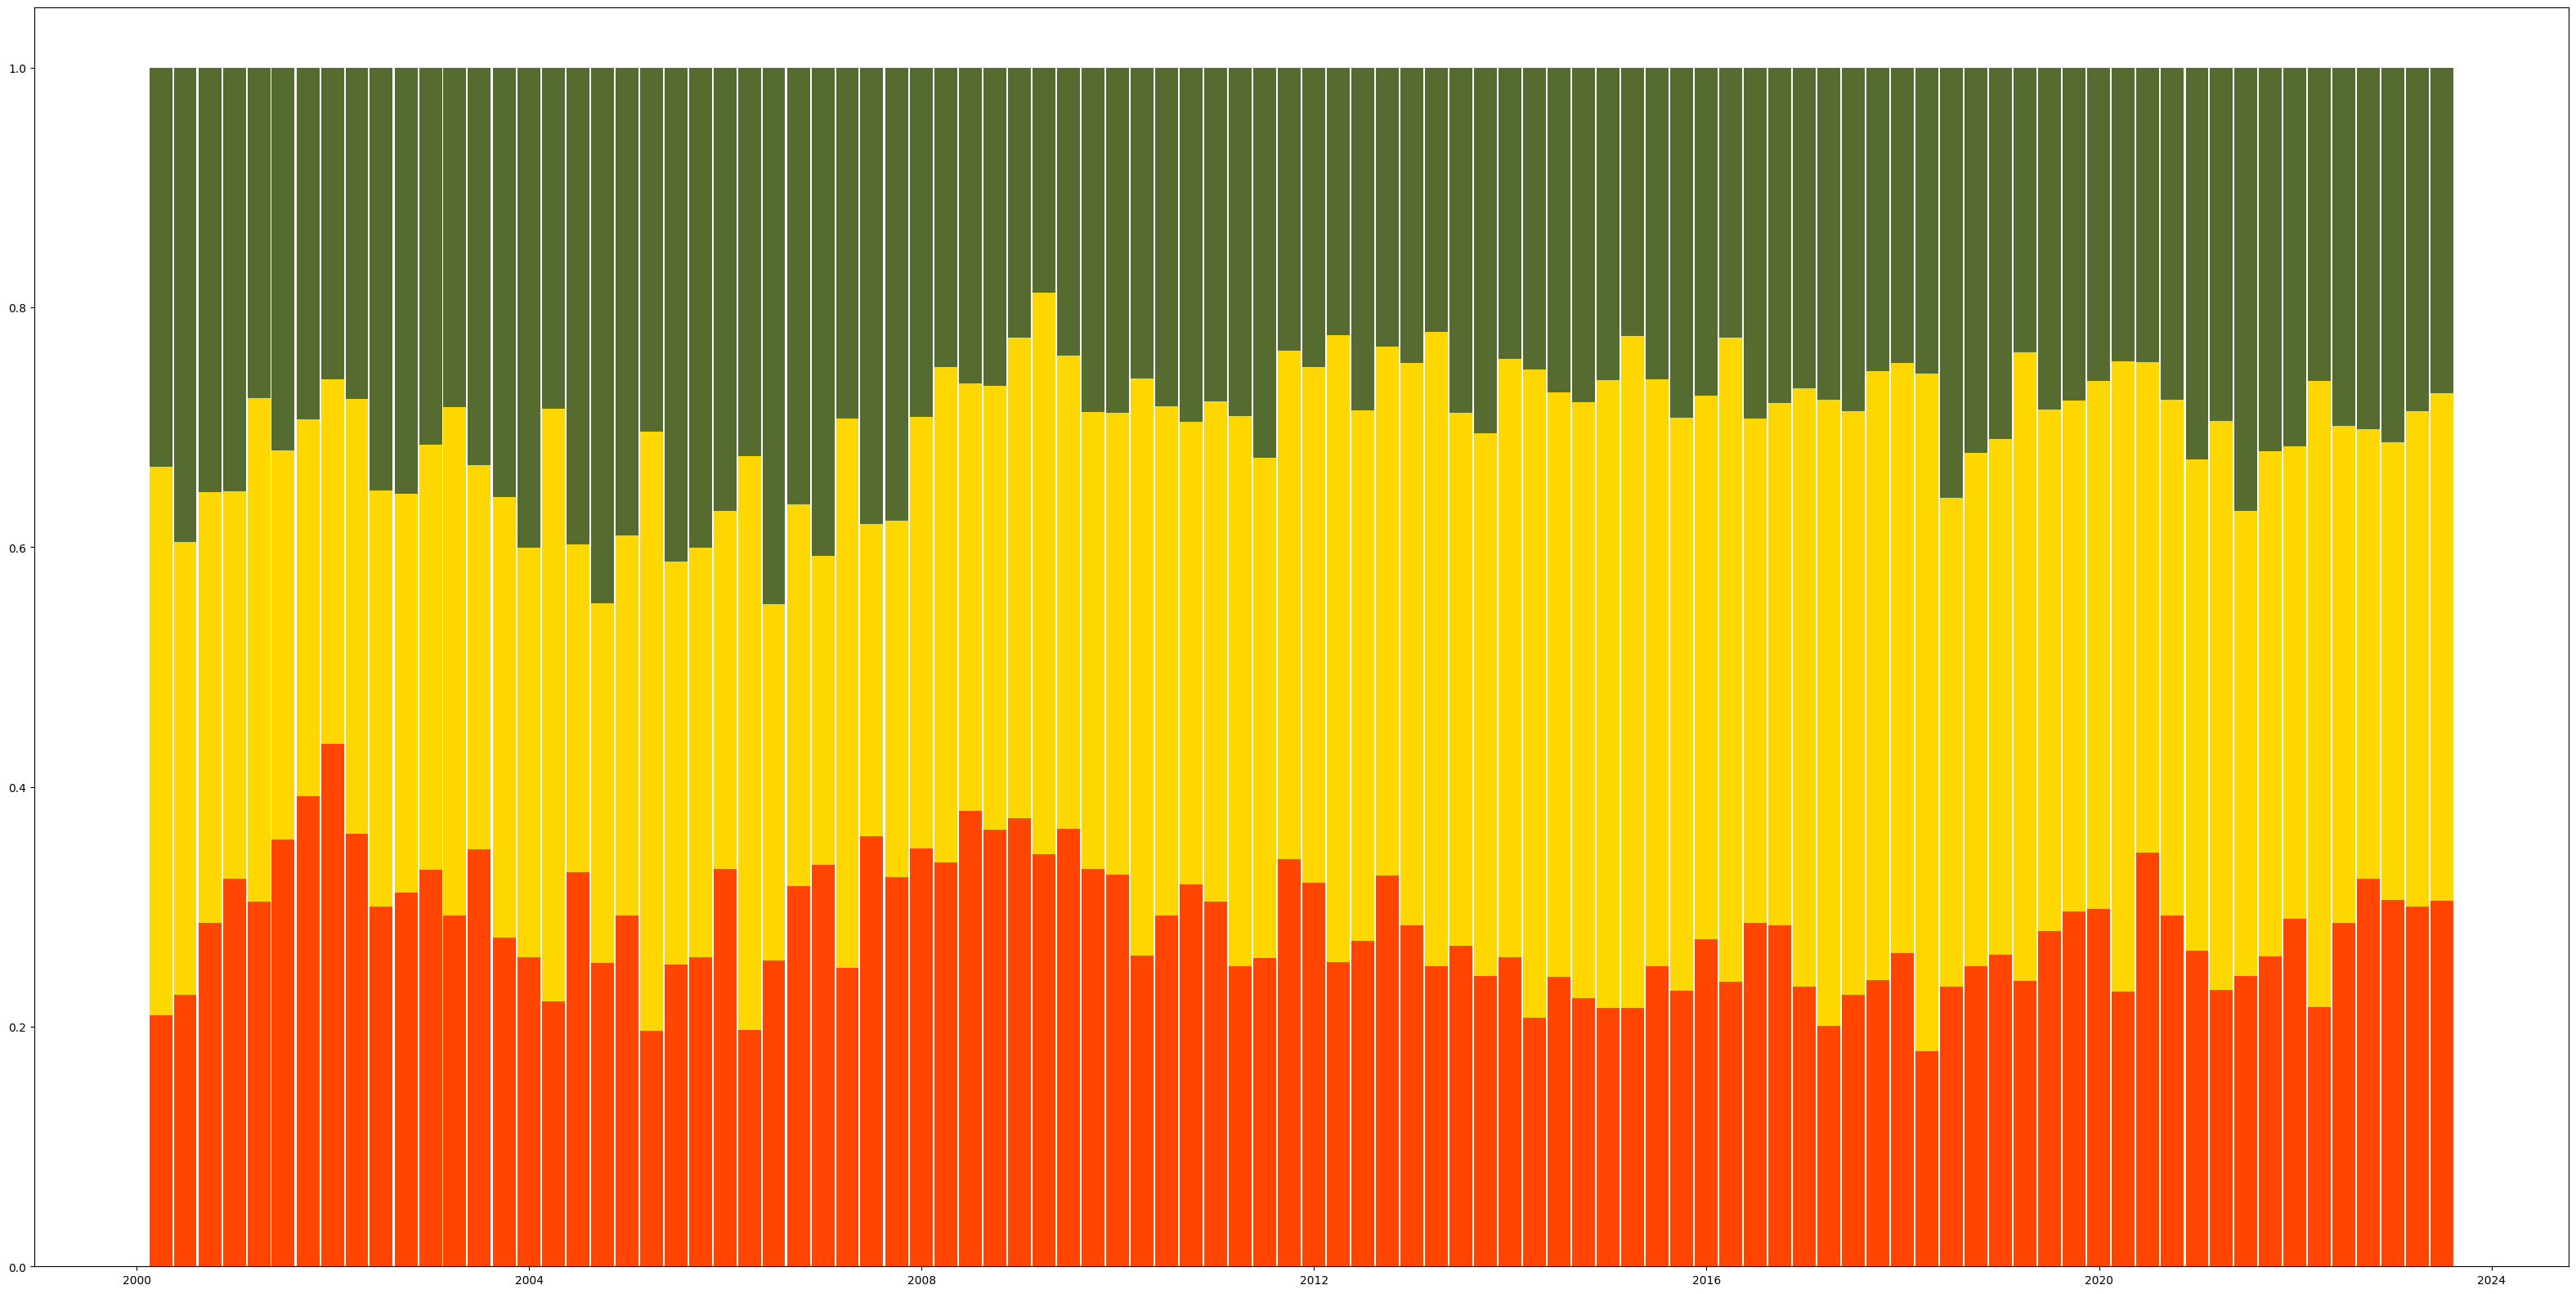

In [64]:
fig, ax = plt.subplots(figsize = (40, 20))
plt.style.use('fivethirtyeight')   
#create a bar graph of the count of positive, negative, and neutral sentiment total
ax.bar(sent_us2['date'], sent_us2['negative'], label='Negative', color='orangered', width=85)
ax.bar(sent_us2['date'], sent_us2['neutral'], label='Neutral', color='gold', width=85, bottom=sent_us2['negative'])
ax.bar(sent_us2['date'], sent_us2['positive'], label='Positive', color='darkolivegreen', width=85, bottom=sent_us2['neutral'] + sent_us2['negative'])



<BarContainer object of 101 artists>

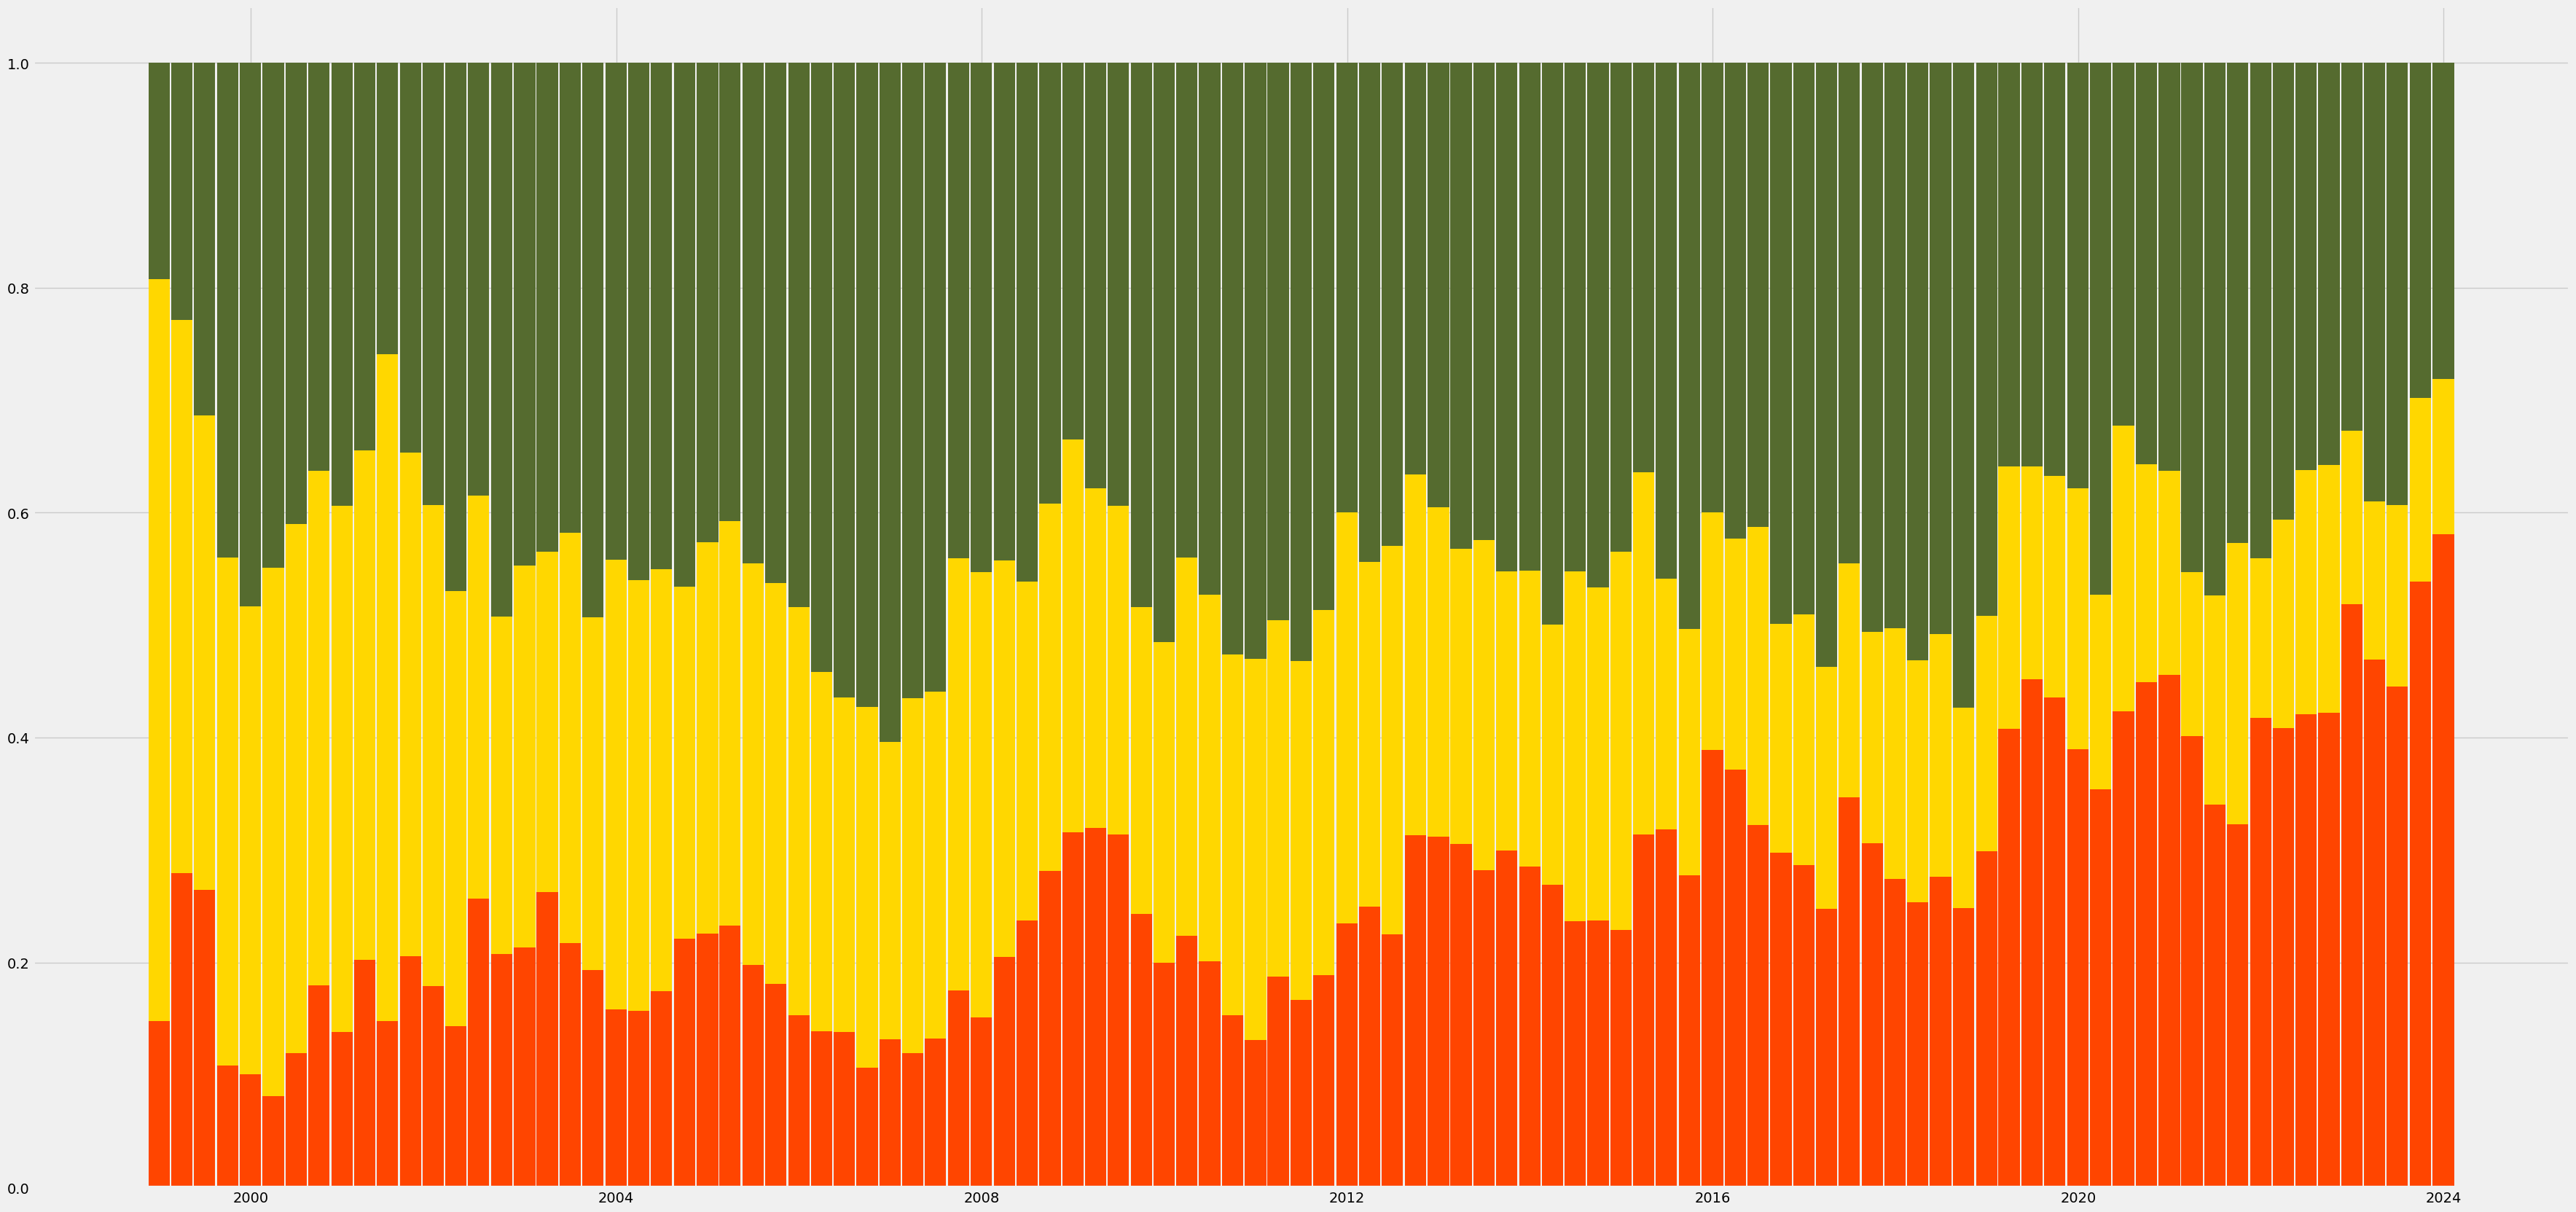

In [65]:
fig, ax = plt.subplots(figsize = (40, 20))
plt.style.use('fivethirtyeight')   
#create a bar graph of the count of positive, negative, and neutral sentiment total
ax.bar(sent_eu2['date'], sent_eu2['negative'], label='Negative', color='orangered', width=85)
ax.bar(sent_eu2['date'], sent_eu2['neutral'], label='Neutral', color='Gold', width=85, bottom=sent_eu2['negative'])
ax.bar(sent_eu2['date'], sent_eu2['positive'], label='Positive', color='darkolivegreen', width=85, bottom=sent_eu2['neutral'] + sent_eu2['negative'])
